In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import torch


def seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 1. CSV 불러오기
df = pd.read_csv("preprocessed_data/Scenario A1-ARFF/Scenario A1-ARFF_15s-VPN.csv")
le = LabelEncoder()
df['class1'] = le.fit_transform(df['class1'])

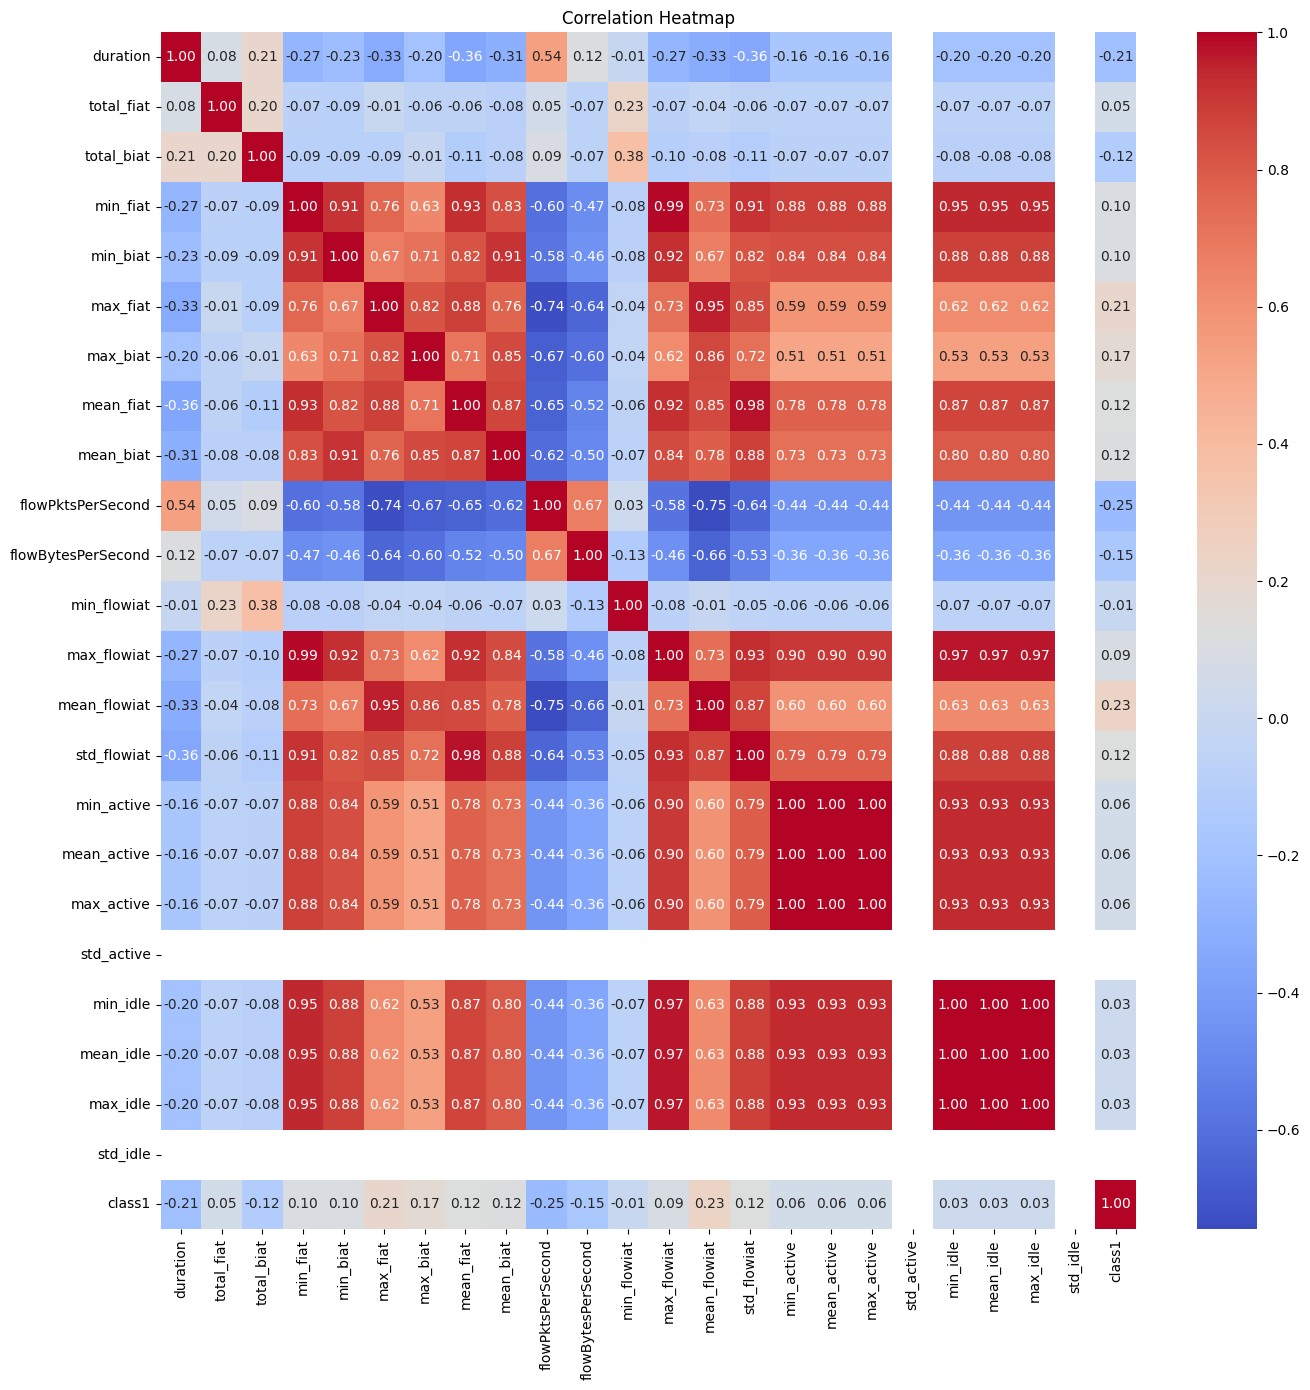

std_active 는 상수 — 제거 대상
std_idle 는 상수 — 제거 대상
total_fiat 는 상관관계가 거의 없음 - 제거 대상
min_flowiat 는 상관관계가 거의 없음 - 제거 대상
max_flowiat 는 상관관계가 거의 없음 - 제거 대상
min_active 는 상관관계가 거의 없음 - 제거 대상
mean_active 는 상관관계가 거의 없음 - 제거 대상
max_active 는 상관관계가 거의 없음 - 제거 대상
min_idle 는 상관관계가 거의 없음 - 제거 대상
mean_idle 는 상관관계가 거의 없음 - 제거 대상
max_idle 는 상관관계가 거의 없음 - 제거 대상
min_biat 와 min_fiat 의 상관관계가 0.9 이상 min_fiat - 제거 대상
min_fiat 와 std_flowiat 의 상관관계가 0.9 이상 std_flowiat - 제거 대상
mean_biat 와 min_biat 의 상관관계가 0.9 이상 min_biat - 제거 대상
max_fiat 와 mean_flowiat 의 상관관계가 0.9 이상 mean_flowiat - 제거 대상
max_flowiat 와 mean_fiat 의 상관관계가 0.9 이상 mean_fiat - 제거 대상
최종 제거할 컬럼들: 16 ['max_active', 'max_flowiat', 'max_idle', 'mean_active', 'mean_fiat', 'mean_flowiat', 'mean_idle', 'min_active', 'min_biat', 'min_fiat', 'min_flowiat', 'min_idle', 'std_active', 'std_flowiat', 'std_idle', 'total_fiat']


In [17]:
fig, ax = plt.subplots(figsize=(14, 14))

# 상관관계 히트맵
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
ax.set_title('Correlation Heatmap')

plt.tight_layout()
plt.show()

remove_col = []

# 1. 상수값 컬럼
for col in df.columns:
    if df[col].nunique() <= 1:
        print(f"{col} 는 상수 — 제거 대상")
        remove_col.append(col)

# 2. class1과 상관관계가 거의 없는 컬럼
low_corr_features = corr['class1'].abs()[corr['class1'].abs() < 0.1].index.tolist()
for col in low_corr_features:
    if col not in remove_col:
        print(f"{col} 는 상관관계가 거의 없음 - 제거 대상")
        remove_col.append(col)

# 3. 상호 상관관계가 0.9 이상인 컬럼 쌍 중 하나 제거
high_corr_pairs = []
for i in corr.columns:
    for j in corr.columns:
        if i != j and abs(corr.loc[i, j]) > 0.9:
            pair = tuple(sorted((i, j)))
            if pair not in high_corr_pairs:
                high_corr_pairs.append(pair)

# 쌍 중 하나만 제거 (여기선 두 번째 항목 j를 제거)
for i, j in high_corr_pairs:
    if j not in remove_col:
        print(f"{i} 와 {j} 의 상관관계가 0.9 이상 {j} - 제거 대상")
        remove_col.append(j)

# 중복 제거
remove_col = list(set(remove_col))
remove_col.sort()
print("최종 제거할 컬럼들:", len(remove_col), remove_col)

# 4. 실제 삭제
df_cleaned = df.drop(columns=remove_col)

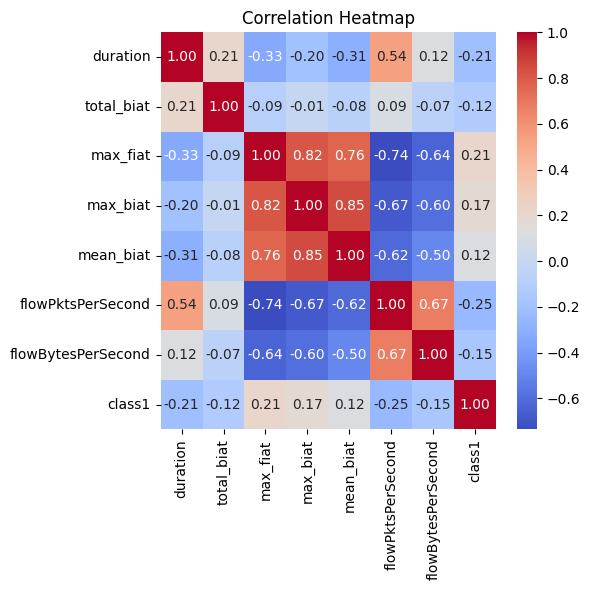

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))

# 상관관계 히트맵
corr = df_cleaned.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
ax.set_title('Correlation Heatmap')

plt.tight_layout()
plt.show()

In [32]:
# 특성과 레이블 나누기
X = df_cleaned.drop(columns=['class1'])
y = df_cleaned['class1']

# train/valid/test 분리
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

In [49]:
# 모델 학습
model = XGBClassifier(eval_metric='logloss', n_estimators=1000)
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=50,
)

# 예측 및 평가 (문자 클래스 복원)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

[0]	validation_0-logloss:0.53571
[50]	validation_0-logloss:0.16041
[100]	validation_0-logloss:0.16789
[150]	validation_0-logloss:0.17748
[200]	validation_0-logloss:0.18186
[250]	validation_0-logloss:0.18664
[300]	validation_0-logloss:0.19169
[350]	validation_0-logloss:0.19683
[400]	validation_0-logloss:0.19884
[450]	validation_0-logloss:0.20122
[500]	validation_0-logloss:0.20309
[550]	validation_0-logloss:0.20508
[600]	validation_0-logloss:0.20679
[650]	validation_0-logloss:0.20820
[700]	validation_0-logloss:0.21023
[750]	validation_0-logloss:0.21100
[800]	validation_0-logloss:0.21303
[850]	validation_0-logloss:0.21405
[900]	validation_0-logloss:0.21513
[950]	validation_0-logloss:0.21600
[999]	validation_0-logloss:0.21724
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       439
           1       0.94      0.95      0.94       442

    accuracy                           0.94       881
   macro avg       0.94      0.94      0.94       

In [45]:
import xgboost
print(xgboost.__version__)

3.0.0


In [164]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class MyMLP(nn.Module):
    def __init__(self, input_size, num_classes, lr=0.001, epochs=50, check = 10, batch_size=64, dropout_rate=0.3):
        super().__init__()
        seed()
        self.model = nn.Sequential(
            nn.Flatten(),
            
            nn.Linear(input_size, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(16, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(8, num_classes)
        )
        self.lr = lr
        self.epochs = epochs
        self.check = check
        self.batch_size = batch_size
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, x):
        return self.model(x)

    def fit(self, X_train, y_train, X_test=None, y_test=None):
        # 데이터 준비
        train_dataset = TensorDataset(
            torch.tensor(X_train.values, dtype=torch.float32),
            torch.tensor(y_train, dtype=torch.long)
        )
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        # 학습
        for epoch in range(1, self.epochs + 1):
            self.train()
            total_loss = 0
            for X_batch, y_batch in train_loader:
                self.optimizer.zero_grad()
                outputs = self.forward(X_batch)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()

            # 정확도 출력
            if epoch % self.check == 0 or epoch == 1 or epoch == self.epochs:
                train_acc = self.evaluate(X_train, y_train)
                if (X_test is not None):
                    test_acc = self.evaluate(X_test, y_test)
                    print(f"Epoch {epoch:05d}/{self.epochs:05d} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
                else:
                    print(f"Epoch {epoch:05d}/{self.epochs:05d} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f}")

    def predict(self, X):
        self.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X.values, dtype=torch.float32)
            outputs = self.forward(X_tensor)
            return torch.argmax(outputs, dim=1).numpy()

    def evaluate(self, X, y):
        if X is None or y is None:
            return 0
        self.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X.values, dtype=torch.float32)
            y_tensor = torch.tensor(y.values, dtype=torch.long)
            outputs = self.forward(X_tensor)
            preds = torch.argmax(outputs, dim=1)
            acc = (preds == y_tensor).float().mean()
        return acc.item()

In [165]:
model = MyMLP(X_train.shape[1], 2, lr=0.00005, epochs=50000, check = 1000, batch_size=128, dropout_rate=0.3)
model.fit(X_train, y_train, X_test, y_test)
valid_acc = model.evaluate(X_valid, y_valid)
print(f"Validation Accuracy: {valid_acc:.4f}")

Epoch 00001/50000 | Loss: 15.3987 | Train Acc: 0.5157 | Test Acc: 0.5199
Epoch 01000/50000 | Loss: 13.3159 | Train Acc: 0.6542 | Test Acc: 0.6697
Epoch 02000/50000 | Loss: 13.1251 | Train Acc: 0.6538 | Test Acc: 0.6663
Epoch 03000/50000 | Loss: 12.8365 | Train Acc: 0.6621 | Test Acc: 0.6686
Epoch 04000/50000 | Loss: 12.5475 | Train Acc: 0.6655 | Test Acc: 0.6742
Epoch 05000/50000 | Loss: 12.5018 | Train Acc: 0.6818 | Test Acc: 0.6867
Epoch 06000/50000 | Loss: 12.1460 | Train Acc: 0.6916 | Test Acc: 0.6935
Epoch 07000/50000 | Loss: 11.9461 | Train Acc: 0.7200 | Test Acc: 0.7003
Epoch 08000/50000 | Loss: 11.8470 | Train Acc: 0.7287 | Test Acc: 0.7196
Epoch 09000/50000 | Loss: 11.7622 | Train Acc: 0.7348 | Test Acc: 0.7287
Epoch 10000/50000 | Loss: 11.6771 | Train Acc: 0.7310 | Test Acc: 0.7264
Epoch 11000/50000 | Loss: 11.6791 | Train Acc: 0.7386 | Test Acc: 0.7367
Epoch 12000/50000 | Loss: 11.6633 | Train Acc: 0.7208 | Test Acc: 0.7094
Epoch 13000/50000 | Loss: 11.4609 | Train Acc: 0.72

KeyboardInterrupt: 

In [167]:
import tensorflow as tf

# 신경망 모델
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        tf.random.set_seed(20)

        num_hidden1 = 100
        num_hidden2 = 100
        num_hidden3 = 100
        num_hidden4 = 100
        
        self.W1 = tf.Variable(tf.random.normal([2, num_hidden1], seed=624))
        self.b1 = tf.Variable(tf.random.normal([num_hidden1], seed=624))

        self.W2 = tf.Variable(tf.random.normal([num_hidden1 , num_hidden2], seed=624))
        self.b2 = tf.Variable(tf.random.normal([num_hidden2], seed=624))

        self.W3 = tf.Variable(tf.random.normal([num_hidden2 , num_hidden3], seed=624))
        self.b3 = tf.Variable(tf.random.normal([num_hidden3], seed=624))

        self.W4 = tf.Variable(tf.random.normal([num_hidden3 , num_hidden4], seed=624))
        self.b4 = tf.Variable(tf.random.normal([num_hidden4], seed=624))

        self.W5 = tf.Variable(tf.random.normal([num_hidden4 , 1], seed=624))
        self.b5 = tf.Variable(tf.random.normal([1], seed=624))

    def call(self, x):
        l1 = tf.matmul(x, self.W1) + self.b1
        h1 = tf.nn.sigmoid(l1)

        l2 = tf.matmul(h1, self.W2) + self.b2
        h2 = tf.nn.sigmoid(l2)

        l3 = tf.matmul(h2, self.W3) + self.b3
        h3 = tf.nn.sigmoid(l3)

        l4 = tf.matmul(h3, self.W4) + self.b4
        h4 = tf.nn.sigmoid(l4)
        
        l5 = tf.matmul(h4, self.W5) + self.b5
        yhat = tf.nn.sigmoid(l5)
        return yhat